# Lab 7 - Learning with time: Time Series and Recurrent Neural Networks

In this lab you will apply the content from the recurrent networks lecture, about how to predict time series. 

At the end of this lab, you should know:
* How to load time-series data for processing
* How to visualise and handle such data in Python
* How to build and train a recurrent neural network from such data. 

In [3]:
from __future__ import division, print_function, unicode_literals,  absolute_import
# Common imports
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

#What are time-series?

Time series analysis is a subfield of statistics and econometrics. A time-series is a sequence of observations recorded at regular time intervals, so time series data $y_t$ is indexed by time $t$ and ordered sequentially. This presents specific challenges including autocorrelation within the data, non-exchangeability of data points, and non-stationarity of data and parameters. Depending on the frequency of observations, a time series may typically be hourly, daily, weekly, monthly, quarterly and annual. Sometimes, you might have seconds and minute-wise time series as well, like, number of clicks and user visits every minute etc.

Because of the sequential nature of the data, time series analysis has particular goals. We can summarize these goals into one of description of a time series in terms of latent components or features of interest, and prediction, which aims to produce reasonable forecasts of the future. Analysis of time-series is the preparatory step before you develop a forecast of the series, and time series forecasting has enormous commercial significance because most information that is important to an organisation, e.g. demand and sales, number of visitors to a website, stock price etc are essentially time series data.

## So how do we import time series data?

The data for a time series are typically stored in .csv files or other spreadsheet formats and contains two columns: the date/time and the measured value. Let’s use the `read_csv()` in the `pandas` package to read the time series dataset (a csv file on Australian Drug Sales) as a pandas dataframe. Adding the `parse_dates=['date']` argument will make the date column to be parsed as a date field.

In [4]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Import as Dataframe
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


Alternately, you can import it as a pandas `Series` with the date as index. You just need to specify the `index_col` argument in the `pd.read_csv()` to do this.

In [5]:
ser = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
ser.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


## Visualising a time-series
We can use `matplotlib` to take a look

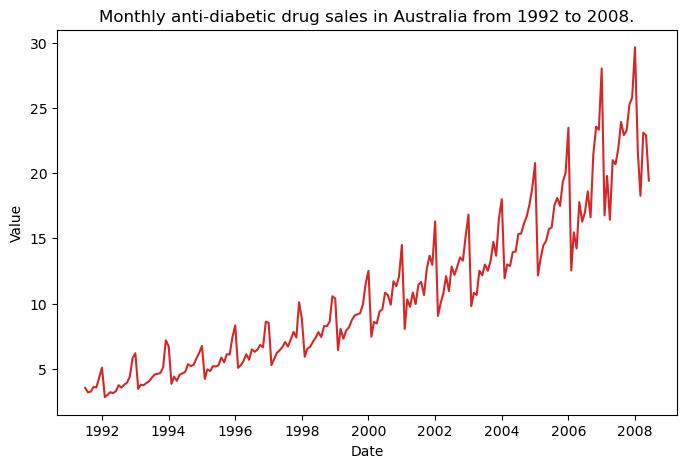

In [6]:
# Time series data source: fpp pacakge in R.
import matplotlib.pyplot as plt
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(8,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.') 

## Seasonal plots
You might choose to compare years by plotting by month.. 

Text(0.5, 1.0, 'Seasonal Plot of Drug Sales Time Series')

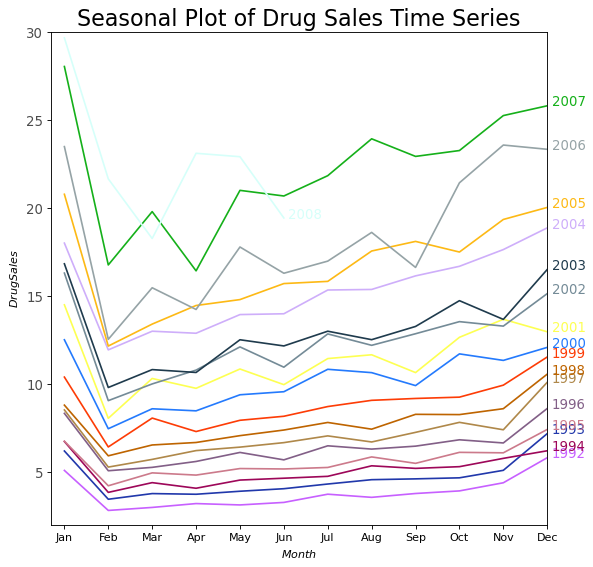

In [7]:
# Import Data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(8,8), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'value', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Drug Sales$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Drug Sales Time Series", fontsize=20)

Any time series may be split into the following components: Base Level + Trend + Seasonality + Error

A trend is observed when there is an increasing or decreasing slope observed in the time series. Whereas seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. It could be because of the month of the year, the day of the month, weekdays or even time of the day.

However, It is not mandatory that all time series must have a trend and/or seasonality. A time series may not have a distinct trend but have a seasonality. The opposite can also be true.

So, a time series may be imagined as a combination of the trend, seasonality and the error terms.

<Axes: title={'center': 'Trend and Seasonality'}, xlabel='date'>

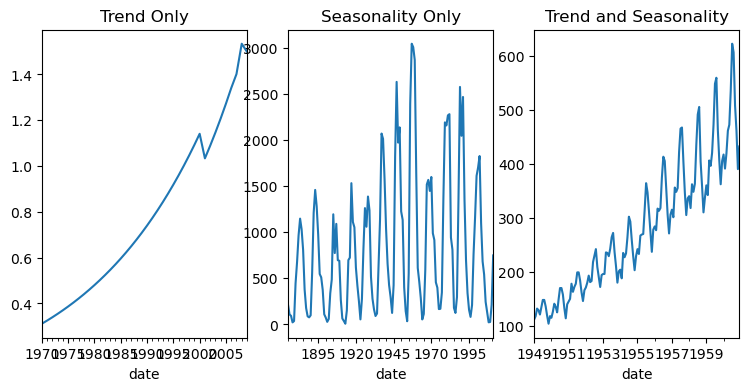

In [8]:
fig, axes = plt.subplots(1,3, figsize=(9,4), dpi=100)
pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/guinearice.csv', parse_dates=['date'], index_col='date').plot(title='Trend Only', legend=False, ax=axes[0])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv', parse_dates=['date'], index_col='date').plot(title='Seasonality Only', legend=False, ax=axes[1])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', parse_dates=['date'], index_col='date').plot(title='Trend and Seasonality', legend=False, ax=axes[2])

# Recurrent Neural Networks

## Generate data

Look at this code and see how it is working.

What is the nature of the y_t and y_t2 datapoints?

What is the "gen_func" function doing?

Why would a RNN be appropriate for modelling such data?

In [9]:
def gen_func(y_t, y_t2):
    e = np.random.normal(scale=0.01)
    return (0.8 - 0.5 * np.exp(-y_t**2)) * y_t + 0.1*np.sin(np.pi*y_t) \
        - (0.3 + 0.9 * np.exp(-y_t**2)) * y_t2 + e
    
def generate_data(n=100):  
    y_t = 0.1
    y_t2 = 0.1
    data = []
    for i in range(n):
        y_new = gen_func(y_t, y_t2)
        data.append([i, y_new, y_t, y_t2])
        y_t2 = y_t
        y_t = y_new
    return np.array(data)

In [10]:
data = generate_data(n=1000)

# Print out the first 10 data points "time points" generated.
data[0:9,]

array([[ 0.        , -0.04390523,  0.1       ,  0.1       ],
       [ 1.        , -0.15457177, -0.04390523,  0.1       ],
       [ 2.        , -0.04470038, -0.15457177, -0.04390523],
       [ 3.        ,  0.17107498, -0.04470038, -0.15457177],
       [ 4.        ,  0.15796644,  0.17107498, -0.04470038],
       [ 5.        , -0.10301626,  0.15796644,  0.17107498],
       [ 6.        , -0.24994347, -0.10301626,  0.15796644],
       [ 7.        , -0.03426427, -0.24994347, -0.10301626],
       [ 8.        ,  0.28290478, -0.03426427, -0.24994347]])

## Draw a "phase diagram" of the dynamical system

What is this diagram showing ?

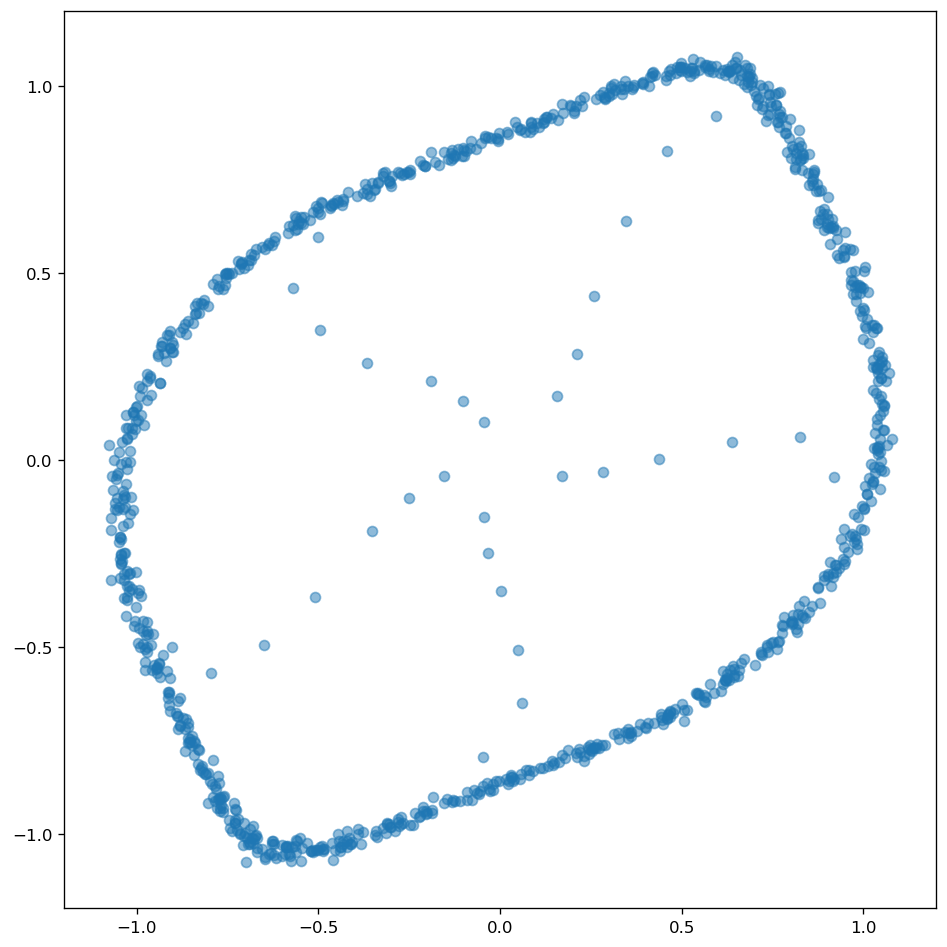

In [11]:

# Plot a phase diagram of the data.

plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.xlim((-1.2,1.2))
plt.ylim((-1.2,1.2))
plt.scatter(data[:,1], data[:,2], alpha=0.5)
plt.tight_layout()
plt.show()

## Developing a LSTM model of this system.

This creates an LSTM model that we will use to model this system.

1. Look at the PyTorch documentation for nn.LSTM and try to work out what "input_dim", "latent_dim" (or "hidden_dim"), "num_layers" and "batch_first" are doing when creating an LSTM layer.

2. What is the fully connected linear layer being used for ? What does it get its input from ?

3. Look at the PyTorch documentation for nn.utils.rnn.pad_sequence. (Look at the example in the documentation given and make sure you understand this.) How is this being used in the code below?

In [12]:
max_length=10

def create_model(input_dim, latent_dim, output_dim, num_layers):

    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.input_dim  = input_dim
            self.hidden_dim = latent_dim
            self.num_layers = num_layers
            self.rnn1   = nn.LSTM(input_dim, latent_dim, num_layers, batch_first = False)
            self.linear = nn.Linear(latent_dim, output_dim)

        def init_hidden(self, batch_size):
          # This is what we'll initialise our hidden state as
          return (torch.zeros(self.num_layers, batch_size, self.hidden_dim), 
                  torch.zeros(self.num_layers, batch_size, self.hidden_dim))
          
        def forward(self, x):
          batch_size = x.size(1)

          h    = self.init_hidden(batch_size)
          y, h = self.rnn1(x,h)

          y = self.linear(y)

          return y, h


    model = Net()

    return model



   
def train_model_on_sequences(model, X, y, epochs, verbose=True):
    
    # pad sequences ``pad_sequence`` stacks a list of Tensors along a new dimension,
    # and pads them to equal length. For example, if the input is list (batch) of
    # sequences with size ``L x *`` and if batch_first is False, returns ``T x B x *``, 
    # where `T` is length of the longest sequence, `B` is batch size.
    X_padded = nn.utils.rnn.pad_sequence(X)
    y_padded = nn.utils.rnn.pad_sequence(y)


    #####################
    # Train model
    #####################

    hist = np.zeros(epochs)
    criterion = nn.MSELoss()
    optimiser = optim.Adam(model.parameters(), lr=0.001)
    #optimiser = optim.RMSprop(model.parameters(), lr=0.001)
    for t in range(epochs):
        # Clear stored gradient
        model.zero_grad()

        y_pred, h = model(X_padded)

        loss = criterion(y_pred, y_padded)
        if t % 100 == 0:
            print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
    print('Done.')    

    
    
def predict_sequence(model, initial_frames, num_steps):
        
        model.eval()
        n, m = initial_frames.shape
        
        preds = [frame for frame in initial_frames]
        last_frames = initial_frames

        # In each prediction step, we feed in the *whole* (predicted) sequence so far,
        # which fits to the stateful=False setup of our LSTM layer (see above).
        with torch.no_grad():
         for step in range(num_steps):
            
              # current number of frames (incl past predictions):
              n_frames = len(last_frames) 
              d = last_frames.reshape(n_frames, m)
              d = torch.from_numpy(d).float()            

              # pad the input sequence to match the model's expected length:
              # Input is a list of tensors.
              d_padded = nn.utils.rnn.pad_sequence([d,])

              # predict and store:
              pred,h = model(d_padded)#,X_lengths)
              this_pred = pred[-1,0:1,:].detach().numpy()
              preds.append(this_pred)

              # add the new prediction to the history/sequence:
              last_frames = np.vstack((last_frames, this_pred))

        preds = np.array(preds)
        model.hidden = model.init_hidden(1)
        return preds.reshape(preds.shape[0], -1)

## Helper functions for generating random subsequences for training

In [13]:
def get_random_subsequence(data, device, seq_length):
    n, m = data.shape
    index = np.random.randint(0, n-seq_length)
    seq = torch.from_numpy(data[index:index+seq_length].reshape(seq_length, -1)).float().to(device)
    return seq

def generate_random_training_sequence(data, device, seq_length):
    frames = get_random_subsequence(data, device, seq_length)
    input_frames = frames[:-1]
    next_frames = frames[1:]
    X = input_frames
    y = next_frames
    return X, y
 
def generate_random_training_sequences(data, device, n, seq_length):
    X_all = []
    y_all = []
    for i in range(n):
        X, y = generate_random_training_sequence(data, device, seq_length)
        X_all.append(X)
        y_all.append(y)
    return X_all, y_all    

## Create the model
You can experiment with the impact of changing `latent_dim`.

What is this representing in terms of the LSTM structure given in the lecture? (Does this make sense in terms of the number of features input to the linear layer?)

In [14]:
# Note: num_layers is the number of recurrent layers. 
# E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN,
# with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1

model = create_model(input_dim=1, latent_dim=4, output_dim=1, num_layers=1)
model = model.to(device)
print(model)

Net(
  (rnn1): LSTM(1, 4)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


## Train the model

Do you understand what is being input to "generate_random_training_sequences" ? What is being generated by this function ?

For longer training, re-run this cell multiple times, or increase the number of epochs.

In [15]:
X_list, y_list = generate_random_training_sequences(
    data[:,1:2], device, n=100, seq_length=10)

train_model_on_sequences(model, X_list, y_list, epochs=10000)

Epoch  0 MSE:  0.6468005776405334
Epoch  100 MSE:  0.492173433303833
Epoch  200 MSE:  0.4407873749732971
Epoch  300 MSE:  0.32699552178382874
Epoch  400 MSE:  0.16323746740818024
Epoch  500 MSE:  0.10102222114801407
Epoch  600 MSE:  0.08004220575094223
Epoch  700 MSE:  0.0677357017993927
Epoch  800 MSE:  0.06050845608115196
Epoch  900 MSE:  0.05635680630803108
Epoch  1000 MSE:  0.05399626865983009
Epoch  1100 MSE:  0.05265448987483978
Epoch  1200 MSE:  0.05186469480395317
Epoch  1300 MSE:  0.05136197805404663
Epoch  1400 MSE:  0.05100821331143379
Epoch  1500 MSE:  0.050735075026750565
Epoch  1600 MSE:  0.05050875246524811
Epoch  1700 MSE:  0.05031169578433037
Epoch  1800 MSE:  0.05013405159115791
Epoch  1900 MSE:  0.04996974766254425
Epoch  2000 MSE:  0.049814656376838684
Epoch  2100 MSE:  0.049665678292512894
Epoch  2200 MSE:  0.049520332366228104
Epoch  2300 MSE:  0.0493764691054821
Epoch  2400 MSE:  0.04923214763402939
Epoch  2500 MSE:  0.04908549413084984
Epoch  2600 MSE:  0.048934

### Predict and plot as time series

Try changing the parameters `window` and `frame_start`

Why do you think it is more accurate if you increase the window size?

Why do you think it is more accurate if you predict from a later frame_start ?

In [16]:
frames = data[:,1].reshape(-1,1)

frame_start = 1
num_preds = 40
window = 3

preds = predict_sequence(
    model, 
    initial_frames=frames[frame_start:frame_start+window],
    num_steps=num_preds)

preds = preds.T[0]

n=50
plt.figure(figsize=(8,4))
ax = plt.subplot(111)
plt.plot(data[:n,0], data[:n,1], c='k')
plt.plot(data[frame_start:frame_start+num_preds+window,0], preds, c='r')
plt.scatter(data[frame_start,0], preds[0], s=96, c='r')
plt.scatter(data[frame_start+num_preds,0], preds[num_preds], s=96, c='r')
plt.tight_layout()
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (43, 1) + inhomogeneous part.

Black is the actual sequence, red is the predicted one.

### Predict and plot as phase portrait

Again change the window size, num_preds and frame_start to get an idea of how the model is behaving.

In [ ]:
# Predict model values.

frames = data[:,1].reshape(-1,1)

frame_start = 1
num_preds = 300
window = 3

preds = predict_sequence(
    model, 
    initial_frames=frames[frame_start:frame_start+window],
    num_steps=num_preds)

preds = preds.T[0]

# Plot phase diagrams.

plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.xlim((-1.2,1.2))
plt.ylim((-1.2,1.2))
plt.scatter(data[:,2], data[:,3], alpha=0.5)
plt.scatter(preds[1:], preds[:-1], alpha=0.5, c='r')
plt.tight_layout()
plt.show()

## Other time-series data
Now that you have your model running on one problem, can you adapt it to another? Take e.g. the sunspots or the anti-diabetic drug historical data from above and build an LSTM model. Compare it to trying to predict with static network, based on delayed inputs. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,1, figsize=(9,4), dpi=100)
sunspots_frame = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv', parse_dates=['date'], index_col='date')
diabetic_frame = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
sunspots_frame.plot(title='Sunspots', legend=False, ax=axes)
sunspots_index = sunspots_frame.index
sunspots = sunspots_frame.to_numpy()

fig, axes = plt.subplots(1,1, figsize=(9,4), dpi=100)
diabetic_frame.plot(title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008', legend=False, ax=axes)
diabetic_index = diabetic_frame.index
diabetic = diabetic_frame.to_numpy()